# Invariant causal representation learning for out-of-distribution generalization
Implementation of: https://openreview.net/pdf?id=-e4EXDWXnSn

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
from torch.distributions import Distribution
import torch.distributions as dist

In [2]:
class SynthNN(nn.Module):
    def __init__(self, hidden_size = 6):
        super().__init__()
        self.function = nn.Sequential(
            nn.Linear(in_features=2, out_features=hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=10),
        )
    def forward(self, Z):
        return self.function(Z)


def simulate_synthetic_data(samples, function):
    envs = np.array([0.2, 2, 3, 5])
    E = np.random.choice([0,1,2,3], size = samples)

    env = envs[E]
    Z1 = env + np.random.normal(0, 1, size = samples)
    Z2 = 2*env + np.random.normal(0, np.sqrt(2), size = samples)
    Y = Z1 + Z2 + np.random.normal(0, 1, size = samples)
    Z = np.stack([Z1, Z2], axis = 1)

    if function == 'identity':
        X = Z
    elif function == 'linear':
        S = np.random.normal(size = (2,10))
        X = Z@S
    elif function == 'nonlinear':
        synthnn = SynthNN()
        X = synthnn(torch.tensor(Z).float()).detach().numpy()
    
    return X, Y, E, Z, env

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_size, output_size) -> None:
        super().__init__()
        self.linear = nn.Linear(in_features=input_size, out_features=6)
        self.relu = nn.ReLU()
        self.output = nn.Linear(in_features=6, out_features=2*output_size)
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        z = self.output(x)
        return z.chunk(2, dim = -1)

class Decoder(nn.Module):
    def __init__(self, input_size, output_size) -> None:
        super().__init__()
        self.linear = nn.Linear(in_features=input_size, out_features=6)
        self.relu = nn.ReLU()
        self.output = nn.Linear(in_features=6, out_features=output_size)
        
    def forward(self, z):
        z = self.linear(z)
        z = self.relu(z)
        mean = self.output(z)
        return mean

class NLPrior(nn.Module):
    def __init__(self, input_size, output_size) -> None:
        super().__init__()
        self.function = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features=output_size*2)
        )
    def forward(self, x):
        return self.function(x).chunk(2, axis = -1)

class NLClassifier(nn.Module):
    def __init__(self, input_size, output_size) -> None:
        super().__init__()
        self.function = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features=output_size),
            nn.Softmax(dim = -1)
        )
    def forward(self, x):
        return self.function(x)


class Normal_dist(Distribution):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.c = 2 * np.pi * torch.ones(1).to(self.device)
        self._dist = dist.normal.Normal(torch.zeros(1).to(self.device), torch.ones(1).to(self.device))
        self.name = 'gauss'

    def sample(self, mu, v):
        with torch.no_grad():
            eps = self._dist.sample(mu.size()).squeeze()
        scaled = eps.mul(v.sqrt())
        return scaled.add(mu)

    def log_pdf(self, x, mu, v, reduce=True, param_shape=None):
        """compute the log-pdf of a normal distribution with diagonal covariance"""
        if param_shape is not None:
            mu, v = mu.view(param_shape), v.view(param_shape)
        lpdf = -0.5 * (torch.log(self.c) + v.log() + (x - mu).pow(2).div(v))
        if reduce:
            return lpdf.sum(dim=-1)
        else:
            return lpdf

In [4]:
class generalNFprior(nn.Module):
    def __init__(self, hidden_dim, ye_dim, output_size, TNN, lambdaNN, lambdaf):
        super().__init__()
        self.TNN = TNN(hidden_dim, output_size)
        self.lambdaNN = lambdaNN(ye_dim, output_size)
        self.lambdaf = lambdaf(ye_dim, hidden_dim * 2)

    def forward(self, z, ye):
        TNN_params, _ = self.TNN(z)
        lambdaNN_params, _ = self.lambdaNN(ye)
        lambdaf_params, _ = self.lambdaf(ye)

        return TNN_params, lambdaNN_params, lambdaf_params
    
    def log_pdf(self, z, TNN_params, lambdaNN_params, lambdaf_params, reduce = True):
        nn_ = (TNN_params*lambdaNN_params).sum(dim = 1)
        z_cat = torch.cat((z, z.pow(2)), dim = 1)
        f_ = (z_cat * lambdaf_params).sum(dim = 1)

        return nn_ + f_

In [5]:
class iCARL_NF_iVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, y_dim, e_dim, encoder, decoder, priorNN, prior_output = 1, device = 'cpu') -> None:
        super().__init__()
        self.encoder = encoder(input_dim + y_dim + e_dim, hidden_dim).to(device)
        self.decoder = decoder(hidden_dim, input_dim).to(device)
        self.prior = generalNFprior(hidden_dim, y_dim+e_dim, prior_output, priorNN, priorNN, priorNN)

        self.decoder_var = 0.01*torch.ones(1).to(device)
        self.encoder_dist = Normal_dist(device = device)
        self.decoder_dist = Normal_dist(device = device)
    
    def encoder_params(self, x, y, e):
        xye = torch.cat((x, y, e), 1)
        g, logv = self.encoder(xye)
        return g, logv.exp()
    
    def decoder_params(self, z):
        f = self.decoder(z)
        return f, self.decoder_var
    
    def prior_params(self, z, y, e):
        ye = torch.cat((y,e), 1)
        TNN_params, lambdaNN_params, lambdaf_params = self.prior(z, ye)

        return TNN_params, lambdaNN_params, lambdaf_params

    def forward(self, x, y, e):
        encoder_params = self.encoder_params(x, y, e)

        z = self.encoder_dist.sample(*encoder_params)
        
        decoder_params = self.decoder_params(z)

        return decoder_params, encoder_params, z
    
    def elbo(self, x, y, e):

        decoder_params, encoder_params, z = self.forward(x, y, e)
        log_px_z = self.decoder_dist.log_pdf(x, *decoder_params)
        log_qz_xye = self.encoder_dist.log_pdf(z, *encoder_params)
        
        z_temp = z.detach().requires_grad_(requires_grad = True)
        prior_params = self.prior_params(z_temp, y.detach(), e.detach())
        pz_ye = self.prior.log_pdf(z_temp, *prior_params)

        dpz_ye = torch.autograd.grad(pz_ye.mean(), z_temp, create_graph = True, retain_graph=True)[0]
            
        ddpz_ye = torch.autograd.grad(dpz_ye.sum(), z_temp, create_graph = True, retain_graph=True)[0]
            
        SM = (ddpz_ye + 0.5 * dpz_ye.pow(2)).sum(1)
        
        elbo = log_px_z - log_qz_xye + pz_ye.detach()
        
        return elbo.mean()-SM.mean(), elbo.mean(), SM.mean()

In [6]:
class iVAE(nn.Module):
    def __init__(self, encoder, decoder, prior, device = 'cpu') -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.prior = prior

        self.decoder_var = 0.01*torch.ones(1).to(device)

        self.encoder_dist = Normal_dist(device = device)
        self.decoder_dist = Normal_dist(device = device)
        self.prior_dist = Normal_dist(device = device)

    def encoder_params(self, x, y, e):
        xye = torch.cat((x, y, e), 1)
        g, logv = self.encoder(xye)
        return g, logv.exp()

    def decoder_params(self, s):
        f = self.decoder(s)
        return f, self.decoder_var

    def prior_params(self, y, e):
        ye = torch.cat((y, e), 1)
        mean, logl = self.prior(ye)
        return mean, logl.exp()

    
    def forward(self, x, y, e, training = True):
        encoder_params = self.encoder_params(x, y, e)

        z = self.encoder_dist.sample(*encoder_params)
        
        decoder_params = self.decoder_params(z)
        prior_params = self.prior_params(y, e)

        if training:
            return decoder_params, encoder_params, prior_params, z
        else: 
            return encoder_params[0]
    
    def elbo(self, x, y, e, beta = 1):

        decoder_params, encoder_params, prior_params, z = self.forward(x, y, e)
        log_px_z = self.decoder_dist.log_pdf(x, *decoder_params)
        log_qz_xye = self.encoder_dist.log_pdf(z, *encoder_params)
        log_pz_ye = self.prior_dist.log_pdf(z, *prior_params)

        kl = -log_qz_xye + log_pz_ye

        elbo = log_px_z + beta*kl

        return elbo.mean()

In [7]:
from torch.utils.data import Dataset, DataLoader

class EnvDataset(Dataset):
    def __init__(self, X, Y, E):
        super().__init__()
        self.X = torch.tensor(X)
        self.Y = torch.tensor(Y).unsqueeze(1)
        self.E = torch.nn.functional.one_hot(torch.tensor(E))
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index], self.E[index] 
    
    def __len__(self):
        return(len(self.X))


### Define networks with specified parameters

In [8]:
encoder = Encoder(input_size=15, output_size=2)
decoder = Decoder(input_size=2, output_size=10)
prior = NLPrior(input_size=5, output_size=2)

net = iVAE(encoder, decoder, prior)

/Users/theb/miniconda3/lib/python3.9/site-packages/torch/distributions/distribution.py:45: UserWarning: <class '__main__.Normal_dist'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


In [9]:
iCARL = iCARL_NF_iVAE(10, 2, 1, 4, Encoder, Decoder, NLPrior, prior_output = 1, device = 'cpu')

### Generate data

In [10]:

X, Y, envs, Z, E = simulate_synthetic_data(8000, 'nonlinear')
dset = EnvDataset(X[:4000],Y[:4000],envs[:4000])
train_loader = DataLoader(dset, batch_size=128, drop_last=True)
dset = EnvDataset(X[4000:],Y[4000:],envs[4000:])
test_loader = DataLoader(dset, batch_size=128, drop_last=True)


In [11]:
x,y,e = next(iter(train_loader))
elbo = iCARL.elbo(x.float(),y.float(),e.float())

In [12]:
elbo

(tensor(-1278.6198, grad_fn=<SubBackward0>),
 tensor(-1278.6318, grad_fn=<MeanBackward0>),
 tensor(-0.0121, grad_fn=<MeanBackward0>))

In [13]:
from torch.optim import Adam
optimizer = Adam(iCARL.parameters(), lr=1e-3)

In [14]:
epochs = 200
train_loss = torch.zeros(epochs)
elbo_loss = torch.zeros(epochs)
SM_loss = torch.zeros(epochs)
pz_ye_loss = torch.zeros(epochs)

for epoch in range(epochs):
    epoch_loss = 0
    if epoch < 20:
        beta = 10
    else:
        beta = 10
    for x,y,e in train_loader:
        optimizer.zero_grad()
        loss, elbo, SM = iCARL.elbo(x.float(), y.float(), e.float())
        loss.mul(-1).backward()
        optimizer.step()
        epoch_loss += loss.mul(-1).detach()
        
    if (epoch+1)%20 == 0:
        print('Epoch', epoch+1, 'of', epochs)
        print('Train loss:', epoch_loss/len(train_loader))
    train_loss[epoch] = epoch_loss/len(train_loader)
        


Epoch 20 of 200
Train loss: tensor(-565.3650)
Epoch 40 of 200
Train loss: tensor(-2342.4333)
Epoch 60 of 200
Train loss: tensor(-2896.5869)
Epoch 80 of 200
Train loss: tensor(-3691.9568)
Epoch 100 of 200
Train loss: tensor(-4726.7964)
Epoch 120 of 200
Train loss: tensor(-5418.9858)
Epoch 140 of 200
Train loss: tensor(-6185.9648)
Epoch 160 of 200
Train loss: tensor(-6773.6577)
Epoch 180 of 200
Train loss: tensor(-7147.1909)
Epoch 200 of 200
Train loss: tensor(-7542.7944)


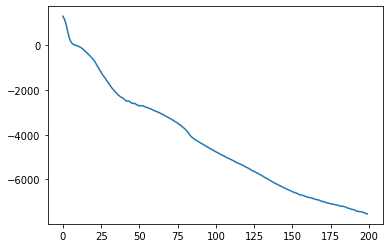

In [15]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.show()


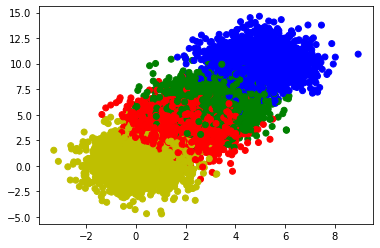

In [16]:
colors = np.array(["r", "g", "b", "y"])
plt.scatter(Z[:,0], Z[:,1], c=colors[envs.astype(int)-1])

In [17]:
# get z
loader = test_loader
latent_variables = torch.zeros((len(train_loader)*128, 2))
envs_samp = np.zeros((len(train_loader)*128, 4))
i = 0
for x,y,e in train_loader:
    _,_,z = iCARL.forward(x.float(), y.float(), e.float())
    latent_variables[i*128:i*128+128,:] = z.detach()
    envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int)
    i+=1

In [18]:
envs_samp_ind = np.argmax(envs_samp, axis = 1)
envs_samp_ind

array([3, 0, 0, ..., 3, 3, 2])

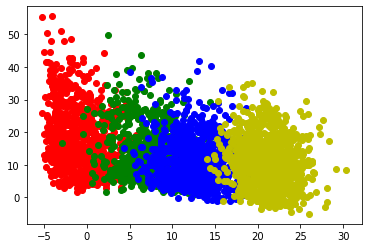

In [19]:
envs_samp_ind = np.argmax(envs_samp, axis = 1)
for env in np.unique(envs_samp_ind):
    idx = envs_samp_ind == env
    plt.scatter(latent_variables[idx,0], latent_variables[idx,1], c=colors[int(env)])